In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

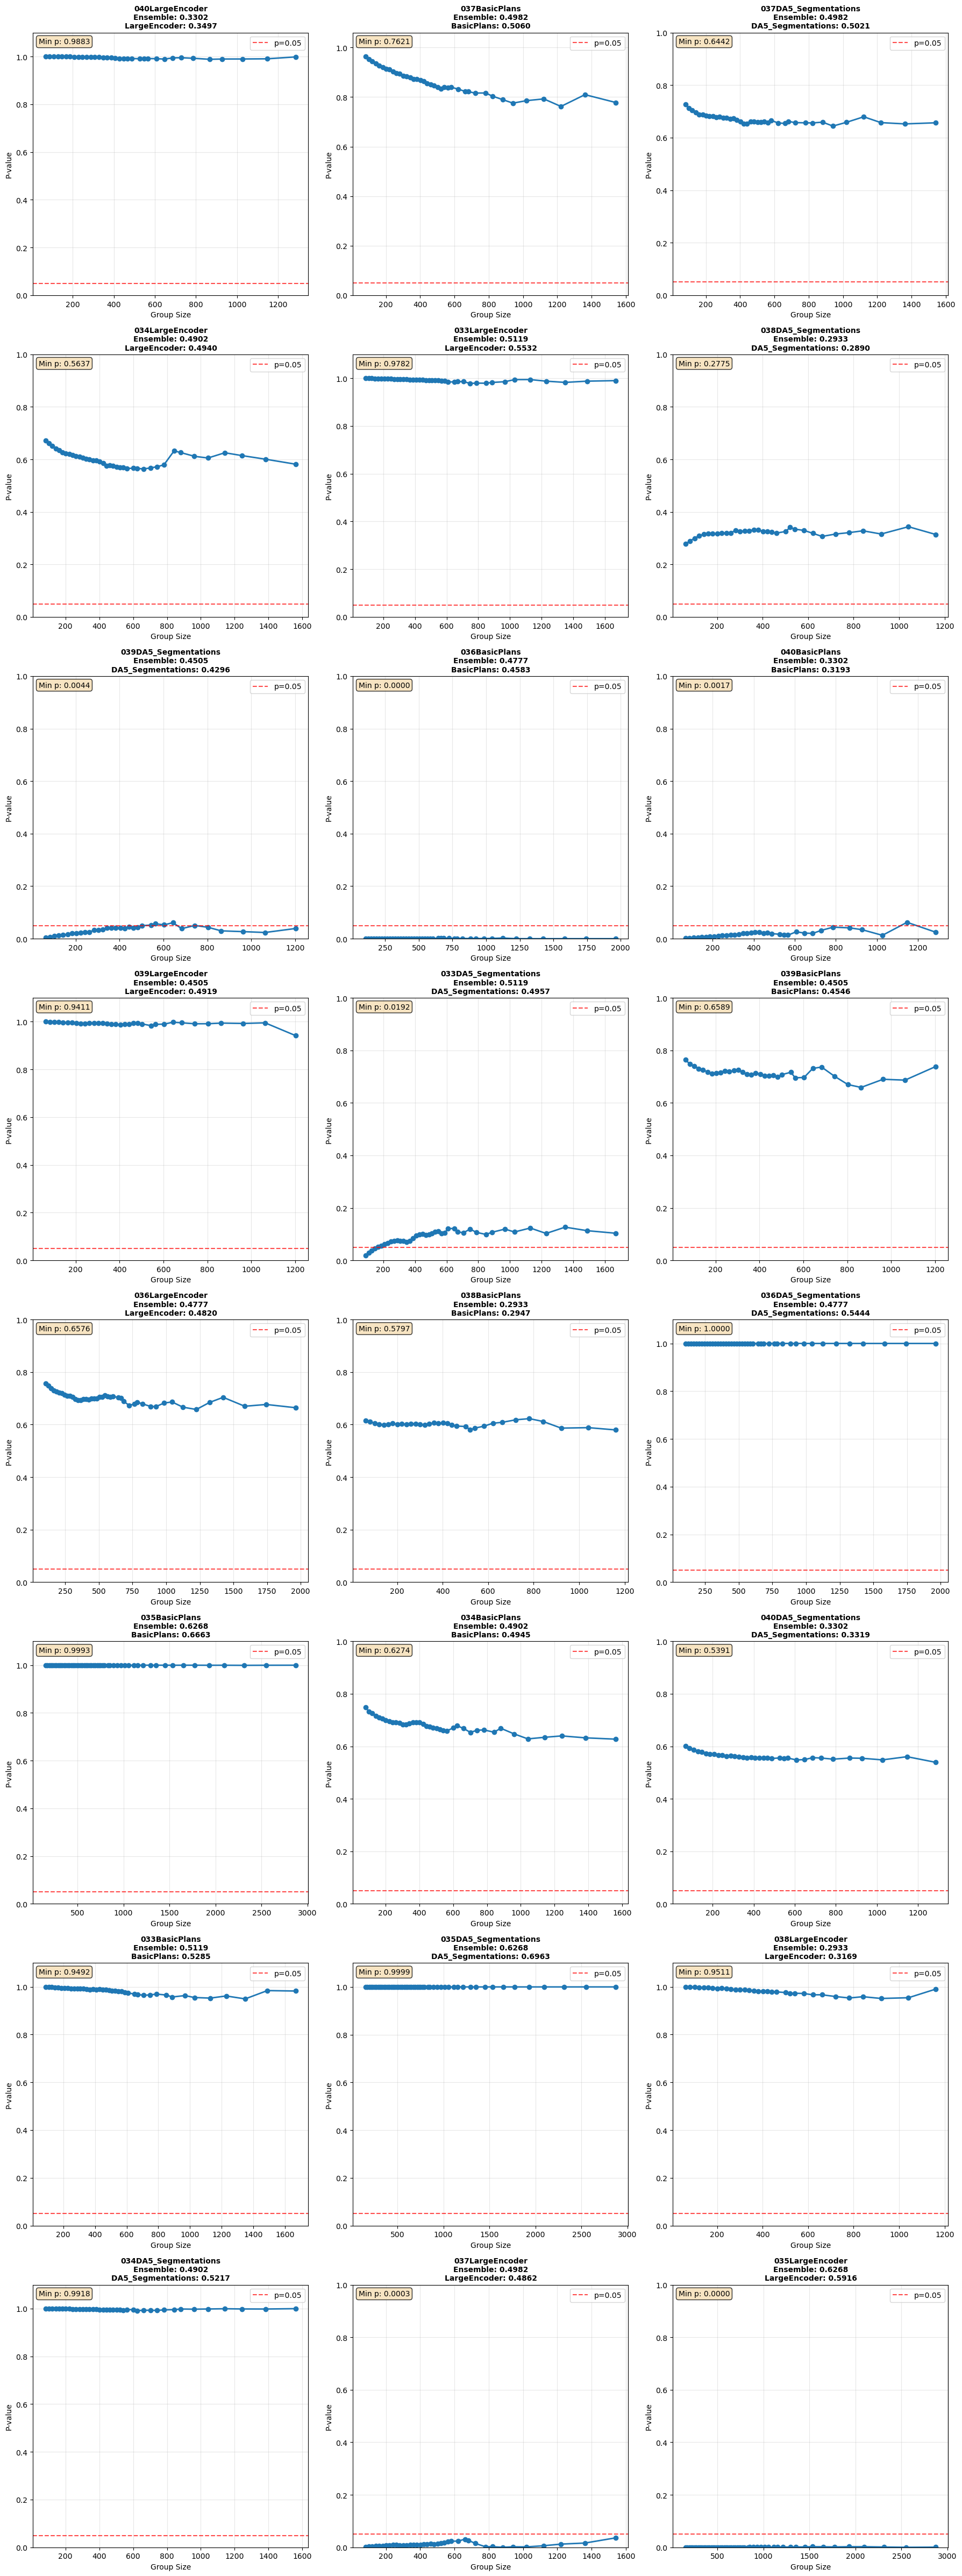


Comparison Summary (Ensemble vs Models):
Image 033 vs BasicPlans:
  Ensemble Sep: 0.5119 | BasicPlans Sep: 0.5285
  Min p-value: 0.949158 | Significant: No

Image 033 vs DA5_Segmentations:
  Ensemble Sep: 0.5119 | DA5_Segmentations Sep: 0.4957
  Min p-value: 0.019230 | Significant: Yes

Image 033 vs LargeEncoder:
  Ensemble Sep: 0.5119 | LargeEncoder Sep: 0.5532
  Min p-value: 0.978220 | Significant: No

Image 034 vs BasicPlans:
  Ensemble Sep: 0.4902 | BasicPlans Sep: 0.4945
  Min p-value: 0.627352 | Significant: No

Image 034 vs DA5_Segmentations:
  Ensemble Sep: 0.4902 | DA5_Segmentations Sep: 0.5217
  Min p-value: 0.991840 | Significant: No

Image 034 vs LargeEncoder:
  Ensemble Sep: 0.4902 | LargeEncoder Sep: 0.4940
  Min p-value: 0.563748 | Significant: No

Image 035 vs BasicPlans:
  Ensemble Sep: 0.6268 | BasicPlans Sep: 0.6663
  Min p-value: 0.999342 | Significant: No

Image 035 vs DA5_Segmentations:
  Ensemble Sep: 0.6268 | DA5_Segmentations Sep: 0.6963
  Min p-value: 0.99986

In [6]:
import re

def parse_performance_file(filename="performance_print.txt"):
    """Parse performance data directly from the text file."""
    performance_data = {}
    
    with open(filename, 'r') as f:
        content = f.read()
    
    # Find the pivot table section
    pivot_start = content.find("Pivot Table (Training Images vs Models):")
    if pivot_start == -1:
        print("Pivot table not found!")
        return {}
    
    # Extract the pivot table section
    pivot_section = content[pivot_start:]
    lines = pivot_section.split('\n')
    
    # Find the header line with model names
    header_line = None
    for i, line in enumerate(lines):
        if 'BasicPlans' in line and 'DA5_Segmentations' in line:
            header_line = line
            data_start_idx = i + 1
            break
    
    if header_line is None:
        print("Header line not found!")
        return {}
    
    # Parse model names from header
    header_clean = re.sub(r'Model\s+', '', header_line)
    models = re.split(r'\s{2,}', header_clean.strip())
    
    # Initialize performance_data structure
    for model in models:
        performance_data[model] = {}
    
    # Parse data lines
    for line in lines[data_start_idx:]:
        line = line.strip()
        if not line or not line[0].isdigit():
            continue
            
        parts = line.split()
        if len(parts) != len(models) + 1:
            continue
            
        image_num = parts[0]
        values = parts[1:]
        
        for model, value in zip(models, values):
            try:
                performance_data[model][image_num] = float(value)
            except ValueError:
                continue
    
    return performance_data

def parse_filename(filename):
    """Extract image number and model name from filename like '033BasicPlans'"""
    for i, char in enumerate(filename):
        if not char.isdigit():
            image_num = filename[:i]
            model_name = filename[i:]
            return image_num, model_name
    return None, None

# Parse the performance data
performance_data = parse_performance_file("performance_print.txt")

# Load pickle data (your existing code)
pickle_dir = "significance_pickles"
if os.path.exists(pickle_dir):
    all_files = os.listdir(pickle_dir)
    pickle_files = [f for f in all_files if f.endswith('.pkl')]
    pickle_files = [os.path.join(pickle_dir, f) for f in pickle_files]
else:
    pickle_files = []
    print("significance_pickles directory not found!")

all_data = {}
for file_path in pickle_files:
    filename = os.path.basename(file_path).replace('.pkl', '')
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            all_data[filename] = data
    except Exception as e:
        print(f"✗ Error loading {filename}: {e}")

# Create enhanced plotting with both ensemble and model separation distances
if all_data:
    n_files = len(all_data)
    cols = min(3, n_files)
    rows = (n_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    
    # Handle different subplot configurations
    if n_files == 1:
        axes = [axes]
    elif rows == 1 and cols > 1:
        axes = list(axes)
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each dataset
    for i, (filename, data) in enumerate(all_data.items()):
        if isinstance(data, dict) and data:
            x_vals = list(data.keys())
            y_vals = list(data.values())
            
            # Sort by x values
            sorted_pairs = sorted(zip(x_vals, y_vals))
            x_vals, y_vals = zip(*sorted_pairs)
            
            axes[i].plot(x_vals, y_vals, 'o-', linewidth=2, markersize=6)
            axes[i].set_xlabel('Group Size')
            axes[i].set_ylabel('P-value')
            axes[i].grid(True, alpha=0.3)
            
            # Add significance line at p=0.05
            axes[i].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='p=0.05')
            
            # Set y-axis limits
            axes[i].set_ylim(0, max(1.0, max(y_vals) * 1.1))
            
            # Parse filename to get performance data
            image_num, model_name = parse_filename(filename)
            
            # Get separation distances for both ensemble and model
            ensemble_sep = None
            model_sep = None
            if image_num and model_name:
                if 'Ensemble' in performance_data:
                    ensemble_sep = performance_data['Ensemble'].get(image_num)
                if model_name in performance_data:
                    model_sep = performance_data[model_name].get(image_num)
            
            # Create enhanced title with both separation distances
            title_parts = [filename]
            if ensemble_sep is not None and model_sep is not None:
                title_parts.append(f"Ensemble: {ensemble_sep:.4f}")
                title_parts.append(f"{model_name}: {model_sep:.4f}")
            
            title = '\n'.join(title_parts)
            axes[i].set_title(title, fontsize=10, fontweight='bold')
            
            # Add min p-value annotation
            min_p = min(y_vals)
            axes[i].text(0.02, 0.98, f'Min p: {min_p:.4f}', 
                        transform=axes[i].transAxes, 
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, f'No data\nin {filename}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{filename} (No Data)", fontsize=12)
    
    # Hide unused subplots
    for i in range(len(all_data), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary sorted by image->model with both separation distances
    print(f"\nComparison Summary (Ensemble vs Models):")
    print("=" * 90)
    
    # Collect and sort results by image, then model
    results = []
    for filename, data in all_data.items():
        if isinstance(data, dict) and data:
            min_p = min(data.values())
            significant = "Yes" if min_p < 0.05 else "No"
            
            image_num, model_name = parse_filename(filename)
            if image_num and model_name:
                ensemble_sep = performance_data.get('Ensemble', {}).get(image_num)
                model_sep = performance_data.get(model_name, {}).get(image_num)
                
                results.append({
                    'image': image_num,
                    'model': model_name,
                    'filename': filename,
                    'min_p': min_p,
                    'significant': significant,
                    'ensemble_sep': ensemble_sep,
                    'model_sep': model_sep
                })
    
    # Sort by image, then by model
    results.sort(key=lambda x: (x['image'], x['model']))
    
    # Print sorted results
    for result in results:
        ensemble_str = f"{result['ensemble_sep']:.4f}" if result['ensemble_sep'] is not None else "N/A"
        model_str = f"{result['model_sep']:.4f}" if result['model_sep'] is not None else "N/A"
        
        print(f"Image {result['image']} vs {result['model']}:")
        print(f"  Ensemble Sep: {ensemble_str} | {result['model']} Sep: {model_str}")
        print(f"  Min p-value: {result['min_p']:.6f} | Significant: {result['significant']}")
        print()

else:
    print("No data to plot")

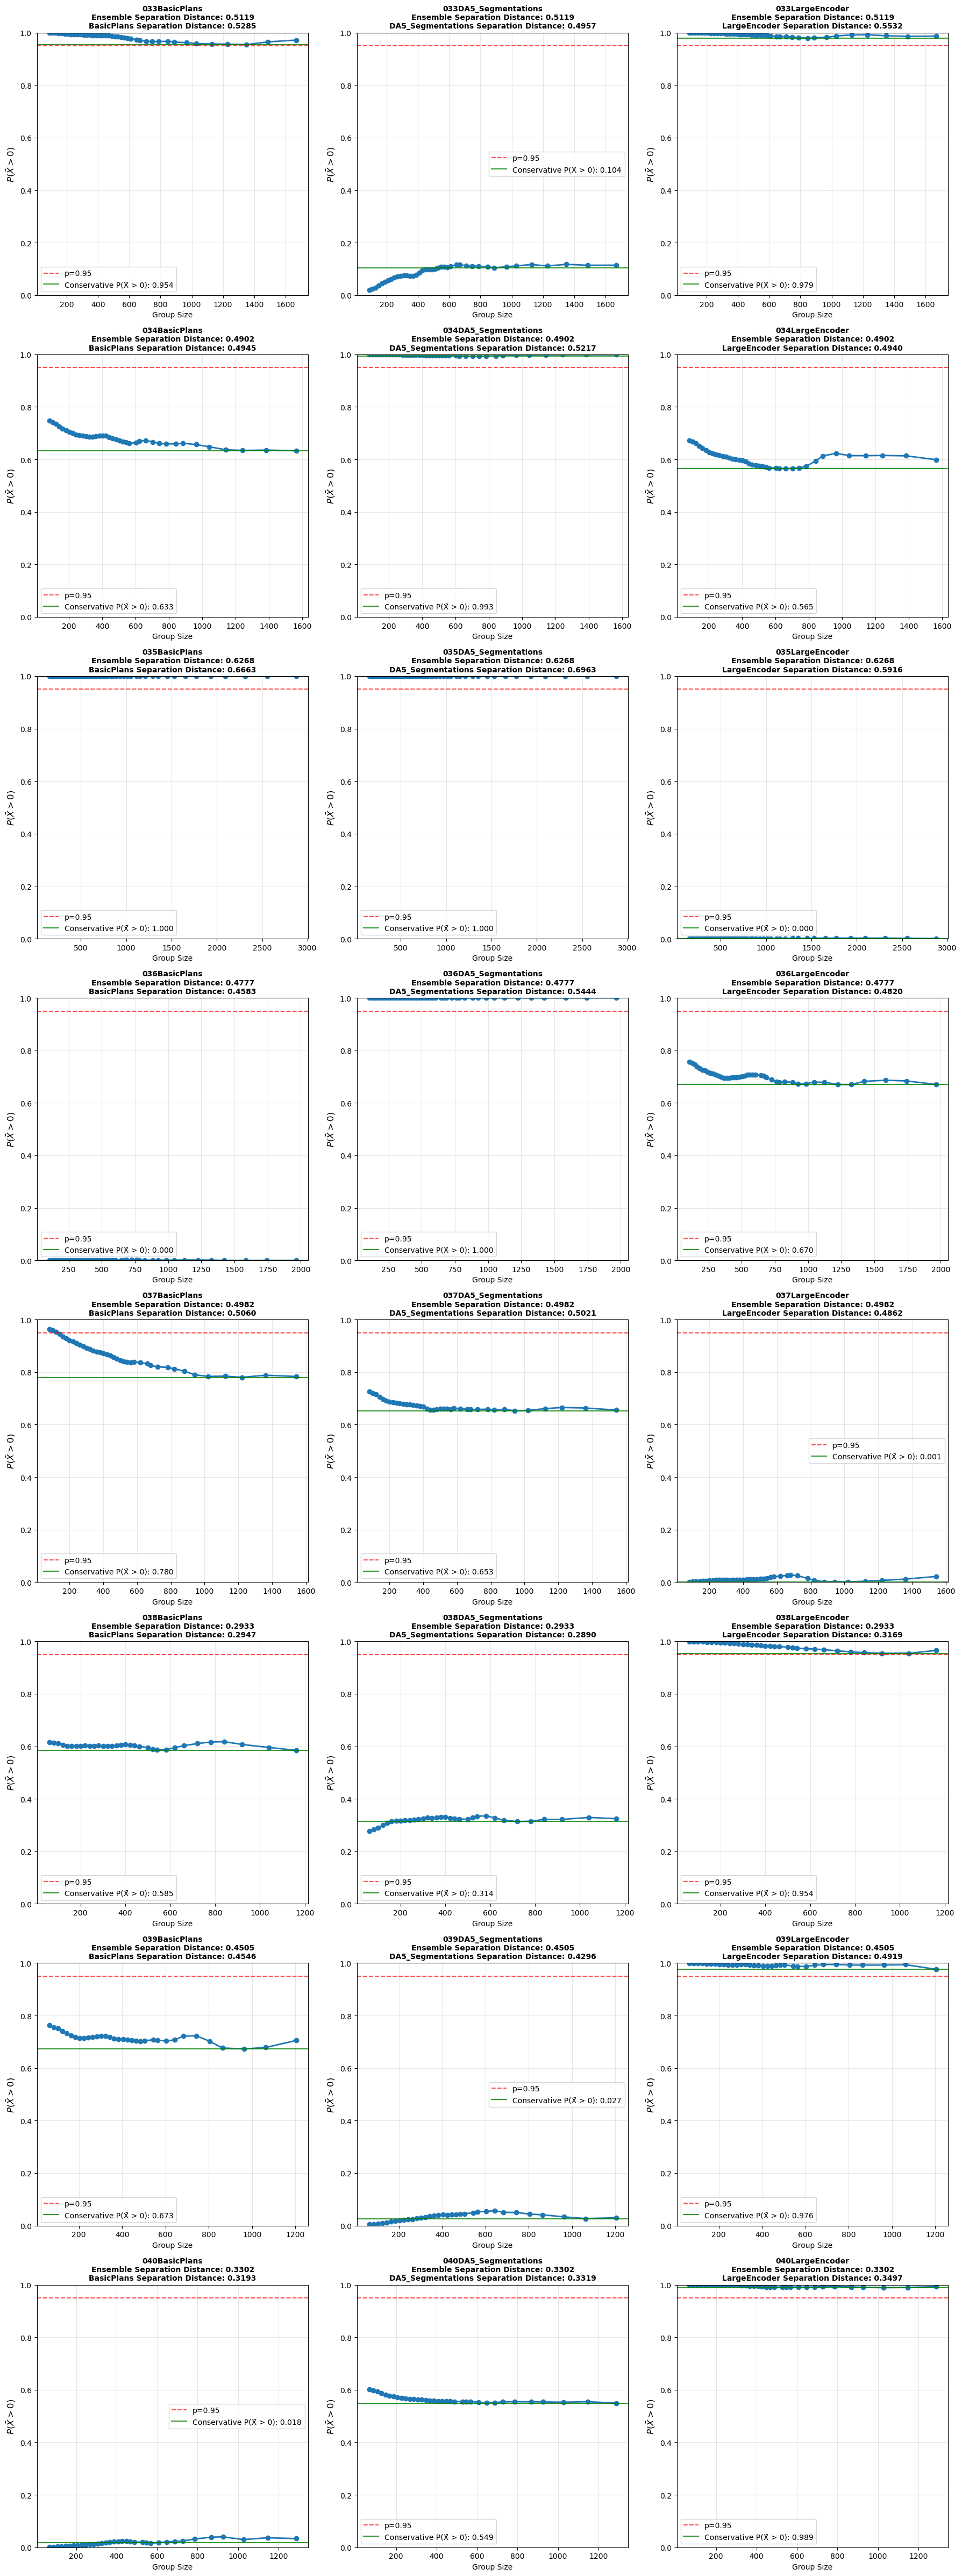


Comparison Summary (Ensemble vs Models):
Image 033 vs BasicPlans:
  Ensemble Separation Distance: 0.5119 | BasicPlans Separation Distance: 0.5285
  Min p-value: 0.954354 | Max p-value: 0.999268 | Significant: Yes

Image 033 vs DA5_Segmentations:
  Ensemble Separation Distance: 0.5119 | DA5_Segmentations Separation Distance: 0.4957
  Min p-value: 0.104433 | Max p-value: 0.126672 | Significant: No

Image 033 vs LargeEncoder:
  Ensemble Separation Distance: 0.5119 | LargeEncoder Separation Distance: 0.5532
  Min p-value: 0.979021 | Max p-value: 0.999902 | Significant: Yes

Image 034 vs BasicPlans:
  Ensemble Separation Distance: 0.4902 | BasicPlans Separation Distance: 0.4945
  Min p-value: 0.633177 | Max p-value: 0.748188 | Significant: No

Image 034 vs DA5_Segmentations:
  Ensemble Separation Distance: 0.4902 | DA5_Segmentations Separation Distance: 0.5217
  Min p-value: 0.992715 | Max p-value: 1.000000 | Significant: Yes

Image 034 vs LargeEncoder:
  Ensemble Separation Distance: 0.49

In [14]:
import re
import numpy as np

def parse_performance_file(filename="performance_print.txt"):
    """Parse performance data directly from the text file."""
    performance_data = {}
    
    with open(filename, 'r') as f:
        content = f.read()
    
    # Find the pivot table section
    pivot_start = content.find("Pivot Table (Training Images vs Models):")
    if pivot_start == -1:
        print("Pivot table not found!")
        return {}
    
    # Extract the pivot table section
    pivot_section = content[pivot_start:]
    lines = pivot_section.split('\n')
    
    # Find the header line with model names
    header_line = None
    for i, line in enumerate(lines):
        if 'BasicPlans' in line and 'DA5_Segmentations' in line:
            header_line = line
            data_start_idx = i + 1
            break
    
    if header_line is None:
        print("Header line not found!")
        return {}
    
    # Parse model names from header
    header_clean = re.sub(r'Model\s+', '', header_line)
    models = re.split(r'\s{2,}', header_clean.strip())
    
    # Initialize performance_data structure
    for model in models:
        performance_data[model] = {}
    
    # Parse data lines
    for line in lines[data_start_idx:]:
        line = line.strip()
        if not line or not line[0].isdigit():
            continue
            
        parts = line.split()
        if len(parts) != len(models) + 1:
            continue
            
        image_num = parts[0]
        values = parts[1:]
        
        for model, value in zip(models, values):
            try:
                performance_data[model][image_num] = float(value)
            except ValueError:
                continue
    
    return performance_data

def parse_filename(filename):
    """Extract image number and model name from filename like '033BasicPlans'"""
    for i, char in enumerate(filename):
        if not char.isdigit():
            image_num = filename[:i]
            model_name = filename[i:]
            return image_num, model_name
    return None, None

def moving_average(data, window=3):
    """Apply a moving average to the data."""
    if len(data) < window:
        return data
    
    smoothed = []
    for i in range(len(data)):
        if i < window - 1:
            # For the first few points, use available data
            smoothed.append(np.mean(data[:i+1]))
        else:
            # Use the window
            smoothed.append(np.mean(data[i-window+1:i+1]))
    
    return smoothed

# Parse the performance data
performance_data = parse_performance_file("performance_print.txt")

# Load pickle data
pickle_dir = "significance_pickles"
if os.path.exists(pickle_dir):
    all_files = os.listdir(pickle_dir)
    pickle_files = [f for f in all_files if f.endswith('.pkl')]
    pickle_files = [os.path.join(pickle_dir, f) for f in pickle_files]
else:
    pickle_files = []
    print("significance_pickles directory not found!")

all_data = {}
for file_path in pickle_files:
    filename = os.path.basename(file_path).replace('.pkl', '')
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            all_data[filename] = data
    except Exception as e:
        print(f"✗ Error loading {filename}: {e}")

# Dictionary to store minimum p-values
p_vals = {}

# Create enhanced plotting with both ensemble and model separation distances
if all_data:
    # Sort data by image number first, then by model name
    sorted_items = []
    for filename, data in all_data.items():
        image_num, model_name = parse_filename(filename)
        if image_num and model_name:
            sorted_items.append((image_num, model_name, filename, data))
    
    # Sort by image number, then by model name
    sorted_items.sort(key=lambda x: (x[0], x[1]))
    
    n_files = len(sorted_items)
    cols = min(3, n_files)
    rows = (n_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    
    # Handle different subplot configurations
    if n_files == 1:
        axes = [axes]
    elif rows == 1 and cols > 1:
        axes = list(axes)
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each dataset in sorted order
    for i, (image_num, model_name, filename, data) in enumerate(sorted_items):
        if isinstance(data, dict) and data:
            x_vals = list(data.keys())
            y_vals = list(data.values())
            
            # Sort by x values
            sorted_pairs = sorted(zip(x_vals, y_vals))
            x_vals, y_vals = zip(*sorted_pairs)
            
            # Apply 3-term moving average
            y_vals_smoothed = moving_average(list(y_vals), window=3)
            
            # Find minimum point after smoothing for group_size > 600
            filtered_data = [(x, y) for x, y in zip(x_vals, y_vals_smoothed) if x > 600]
            
            if filtered_data:
                min_x, min_y = min(filtered_data, key=lambda x: x[1])
                # Store in p_vals dictionary
                p_vals[filename] = min_y
            else:
                # Fallback to overall minimum if no data > 600
                min_idx = np.argmin(y_vals_smoothed)
                min_x = x_vals[min_idx]
                min_y = y_vals_smoothed[min_idx]
                p_vals[filename] = min_y
            
            axes[i].plot(x_vals, y_vals_smoothed, 'o-', linewidth=2, markersize=6)
            axes[i].set_xlabel('Group Size')
            # Updated y-axis label with mathematical notation
            axes[i].set_ylabel(r'$P(\bar{X} > 0)$', fontsize=12)
            axes[i].grid(True, alpha=0.3)
            
            # Add significance line at p=0.95
            axes[i].axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='p=0.95')
            
            # Fixed y-axis limits from 0 to 1
            axes[i].set_ylim(0, 1.0)
            
            # Add horizontal line and label for conservative estimate only if it's for group_size > 600
            if filtered_data:
                # Draw horizontal line at the conservative P(X̄ > 0) value
                axes[i].axhline(y=min_y, color='green', linestyle='-', alpha=0.8, 
                               label=f'Conservative P(X̄ > 0): {min_y:.3f}')
            
            # Get separation distances for both ensemble and model
            ensemble_sep = None
            model_sep = None
            if 'Ensemble' in performance_data:
                ensemble_sep = performance_data['Ensemble'].get(image_num)
            if model_name in performance_data:
                model_sep = performance_data[model_name].get(image_num)
            
            # Create enhanced title with improved separation distance formatting
            title_parts = [filename]
            if ensemble_sep is not None and model_sep is not None:
                title_parts.append(f"Ensemble Separation Distance: {ensemble_sep:.4f}")
                title_parts.append(f"{model_name} Separation Distance: {model_sep:.4f}")
            
            title = '\n'.join(title_parts)
            axes[i].set_title(title, fontsize=10, fontweight='bold')
            
            axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, f'No data\nin {filename}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{filename} (No Data)", fontsize=12)
    
    # Hide unused subplots
    for i in range(len(sorted_items), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary sorted by image->model with both separation distances
    print(f"\nComparison Summary (Ensemble vs Models):")
    print("=" * 90)
    
    # Collect and sort results by image, then model
    results = []
    for image_num, model_name, filename, data in sorted_items:
        if isinstance(data, dict) and data:
            min_p = p_vals[filename]  # Use the smoothed min value
            max_p = max(data.values())
            significant = "Yes" if max_p > 0.95 else "No"
            
            ensemble_sep = performance_data.get('Ensemble', {}).get(image_num)
            model_sep = performance_data.get(model_name, {}).get(image_num)
            
            results.append({
                'image': image_num,
                'model': model_name,
                'filename': filename,
                'min_p': min_p,
                'max_p': max_p,
                'significant': significant,
                'ensemble_sep': ensemble_sep,
                'model_sep': model_sep
            })
    
    # Print sorted results with improved formatting
    for result in results:
        ensemble_str = f"{result['ensemble_sep']:.4f}" if result['ensemble_sep'] is not None else "N/A"
        model_str = f"{result['model_sep']:.4f}" if result['model_sep'] is not None else "N/A"
        
        print(f"Image {result['image']} vs {result['model']}:")
        print(f"  Ensemble Separation Distance: {ensemble_str} | {result['model']} Separation Distance: {model_str}")
        print(f"  Min p-value: {result['min_p']:.6f} | Max p-value: {result['max_p']:.6f} | Significant: {result['significant']}")
        print()

else:
    print("No data to plot")

# Print the p_vals dictionary
print("\nMinimum P-values Dictionary:")
print("=" * 40)
for filename, min_p in p_vals.items():
    print(f"'{filename}': {min_p:.6f}")